In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import time
import os
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [3]:
X_train = np.load('./npy_dd/x_train.npy')
y_train = np.load('./npy_dd/y_train.npy')
X_test=np.load('./npy_dd/x_test.npy')
y_test=np.load('./npy_dd/y_test.npy')

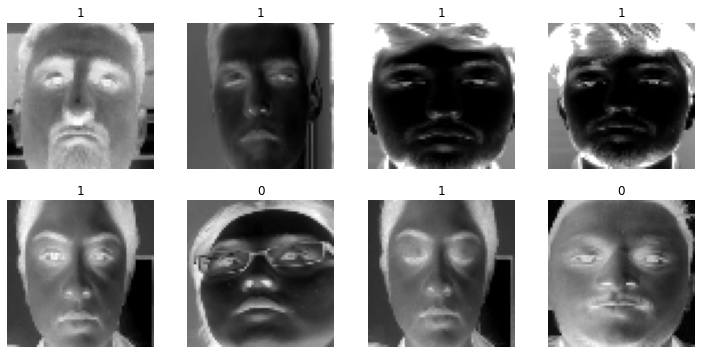

In [4]:
plt.figure(figsize=(10,10))
for i in range(0, 8):
    plt.subplot(440 + 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i*100], cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(y_train[i*100].argmax())    
plt.show()

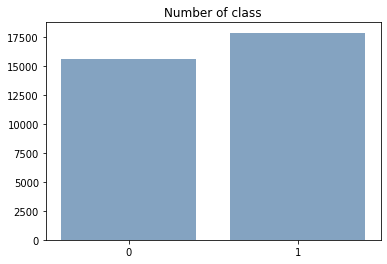

In [5]:
num_class = np.unique(y_train.argmax(axis=1), return_counts=True) 
plt.title("Number of class")
plt.xticks(num_class[0])
plt.bar(num_class[0], num_class[1],color = (0.2, 0.4, 0.6, 0.6) )
plt.show()

In [7]:
X_flat = np.array(X_train).reshape((-1, 64*64))
#X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

In [8]:
X_flat.shape

(33434, 4096)

In [9]:
#Principle Componenet Analysis (PCA)

In [10]:
from sklearn.decomposition import PCA
pca_dims = PCA()
pca_dims.fit(X_flat)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

131

In [11]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_flat)
X_recovered = pca.inverse_transform(X_reduced)

In [12]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (33434, 131)
recovered shape: (33434, 4096)


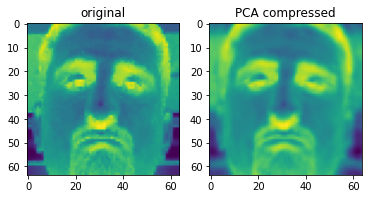

In [13]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

In [14]:
#X = X.reshape(-1, 64, 64, 1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=20)

In [15]:
X_train.shape

(33434, 64, 64)

In [16]:
y_train.shape

(33434, 2)

In [17]:
# Convert Images to Gray scale

In [18]:
X_train = X_train /255
X_test = X_test/255

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Convolution2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Create Model

In [20]:
import keras
from keras import layers,models
from keras.layers import BatchNormalization

from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense,Dropout
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, RMSprop, Adam

In [21]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [22]:
model = Sequential()

# Step 1 - Convolution
model.add(Conv2D(68, (5, 5), input_shape = (64, 64, 1), activation = 'relu'))

# Step 2 - Pooling
model.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
model.add(Conv2D(68, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))


model.add(Conv2D(68, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
model.add(Flatten())

# Step 4 - Full connection
model.add(Dense(units = 256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(units = 2, activation = 'softmax'))

# Compiling the CNN

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 68)        1768      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 68)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 68)        115668    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 68)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 68)          115668    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 68)         0

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# Generate Images
train_datagen = ImageDataGenerator(
                                   shear_range = 0.08,
                                   zoom_range = 0.08,
                                   horizontal_flip = False,
                                   width_shift_range= 0.02,
                                   height_shift_range= 0.02)
test_datagen = ImageDataGenerator(rescale = 1./255)

# fit parameters from data
training_set = train_datagen.flow(X_train, y_train, batch_size=10)
test_set = test_datagen.flow(X_test, y_test, batch_size=10)

history = model.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs =100,
                         validation_data = test_set,
                         validation_steps = 10,
                         verbose=2)

ValueError: ('Input data in `NumpyArrayIterator` should have rank 4. You passed an array with shape', (33434, 64, 64))

In [25]:
scores = classifier.evaluate(X_test, y_test, verbose=1)
print("{}: {:.2f}%".format(classifier.metrics_names[1], scores[1]*100))

NameError: name 'classifier' is not defined

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 
# Predict the values from the validation dataset
Y_pred = classifier.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



NameError: name 'classifier' is not defined

In [27]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.plot(history.history['loss'], color='r', label="training loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [28]:
# Plot the accuracy curve for validation 
plt.plot(history.history['val_acc'], color='g', label="validation accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [29]:
model.save('mycnn_weights_2.h5')
model.load_weights('mycnn_weights_2.h5')

In [30]:
from keras.models import Sequential, Model

In [31]:
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_1').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

#feat_val = model_feat.predict(x_val)
#print(feat_val.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

1045/1045 [==============================] - 48s 46ms/step
(33434, 2)
262/262 [==============================] - 14s 55ms/step
(8359, 2)


In [32]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')

fitting done !!!


In [33]:
Pred_labels = svm.predict(feat_test)

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

              precision    recall  f1-score   support

           0       0.22      0.57      0.32      1487
           1       0.86      0.56      0.68      6872

    accuracy                           0.56      8359
   macro avg       0.54      0.56      0.50      8359
weighted avg       0.74      0.56      0.61      8359



In [36]:
import xgboost as xgb
xb = xgb.XGBClassifier()
xb.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')

fitting done !!!


In [37]:
Pred_labels = xb.predict(feat_test)

In [38]:
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

              precision    recall  f1-score   support

           0       0.32      0.57      0.41      2214
           1       0.79      0.57      0.66      6145

    accuracy                           0.57      8359
   macro avg       0.55      0.57      0.54      8359
weighted avg       0.66      0.57      0.60      8359



In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection

In [40]:
lr = LogisticRegression()
lr.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')

fitting done !!!


In [41]:
Pred_labels = lr.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70      8359

    accuracy                           0.54      8359
   macro avg       0.50      0.27      0.35      8359
weighted avg       1.00      0.54      0.70      8359



In [42]:
dt = DecisionTreeClassifier()
dt.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = dt.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.00      0.68      0.01        28
           1       1.00      0.54      0.70      8331

    accuracy                           0.54      8359
   macro avg       0.50      0.61      0.35      8359
weighted avg       0.99      0.54      0.70      8359



In [43]:
knn = KNeighborsClassifier()
knn.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = knn.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.47      0.48      0.48      3770
           1       0.57      0.55      0.56      4589

    accuracy                           0.52      8359
   macro avg       0.52      0.52      0.52      8359
weighted avg       0.52      0.52      0.52      8359



In [44]:
lda = LinearDiscriminantAnalysis()
lda.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = lda.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.54      0.70      8359

    accuracy                           0.54      8359
   macro avg       0.50      0.27      0.35      8359
weighted avg       1.00      0.54      0.70      8359



In [45]:
nb = GaussianNB()
nb.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = nb.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.13      0.62      0.21       783
           1       0.93      0.55      0.69      7576

    accuracy                           0.56      8359
   macro avg       0.53      0.59      0.45      8359
weighted avg       0.86      0.56      0.65      8359



In [46]:
et = ExtraTreesClassifier()
et.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = et.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.33      0.56      0.42      2281
           1       0.78      0.57      0.66      6078

    accuracy                           0.57      8359
   macro avg       0.55      0.57      0.54      8359
weighted avg       0.66      0.57      0.59      8359



In [47]:
estimators = list()
estimators.append(('RF', RandomForestClassifier()))
estimators.append(('LR', LogisticRegression()))
estimators.append(('DTC', DecisionTreeClassifier()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('NB', GaussianNB()))
#estimators.append(('SVM', GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, min_samples_split=40, min_samples_leaf=7,max_features=4 , subsample=0.95, random_state=10)))
estimators.append(('XGB', XGBClassifier()))

In [48]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')
ensemble.fit(feat_train,np.argmax(y_train,axis=1))
print('fitting done !!!')
Pred_labels = ensemble.predict(feat_test)
print(classification_report(Pred_labels, np.argmax(y_test,axis =1)))

fitting done !!!
              precision    recall  f1-score   support

           0       0.26      0.54      0.35      1859
           1       0.81      0.56      0.66      6500

    accuracy                           0.55      8359
   macro avg       0.53      0.55      0.50      8359
weighted avg       0.69      0.55      0.59      8359



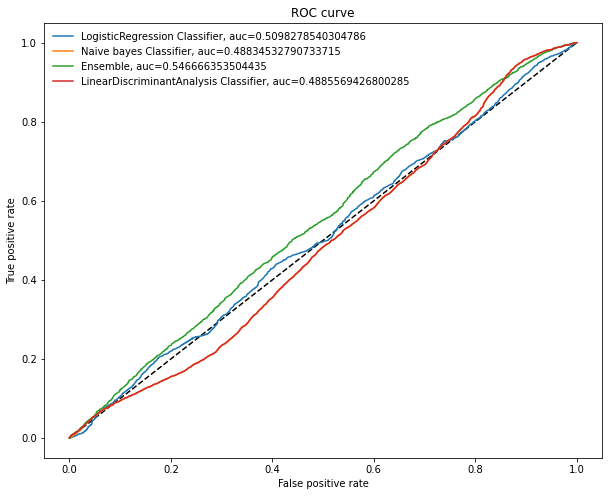

In [49]:
from sklearn import metrics
from sklearn.metrics import roc_curve


clf2=LogisticRegression().fit(feat_train,np.argmax(y_train,axis=1))
y_pred2 = clf2.predict(feat_test)

clf3 = GaussianNB().fit(feat_train,np.argmax(y_train,axis=1))
y_pred3 = clf3.predict(feat_test)

clf4 = ensemble.fit(feat_train,np.argmax(y_train,axis=1))
y_pred4 = clf4.predict(feat_test)

clf6=LinearDiscriminantAnalysis().fit(feat_train,np.argmax(y_train,axis=1))
y_pred6 = clf6.predict(feat_test)

#clf7=SVC(kernel='rbf').fit(feat_train,np.argmax(y_train,axis=1))
#y_pred7 = clf7.predict(feat_test)

y_pred_proba2 = clf2.predict_proba(feat_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba2)
auc2 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba2)

y_pred_proba3 = clf3.predict_proba(feat_test)[::,1]
fpr3, tpr3, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba3)
auc3 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba3)

y_pred_proba4 = clf4.predict_proba(feat_test)[::,1]
fpr4, tpr4, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba4)
auc4 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba4)

y_pred_proba6 = clf6.predict_proba(feat_test)[::,1]
fpr6, tpr6, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba6)
auc6 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba6)

#y_pred_proba7 = clf7.predict_proba(feat_test)[::,1]
#fpr7, tpr7, _ = metrics.roc_curve(np.argmax(y_test,axis =1),  y_pred_proba7)
#auc7 = metrics.roc_auc_score(np.argmax(y_test,axis =1), y_pred_proba7)


plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr2,tpr2,label="LogisticRegression Classifier, auc="+str(auc2))
plt.plot(fpr3,tpr3,label="Naive bayes Classifier, auc="+str(auc3))
plt.plot(fpr4,tpr4,label="Ensemble, auc="+str(auc4))
plt.plot(fpr6,tpr6,label="LinearDiscriminantAnalysis Classifier, auc="+str(auc6))
#plt.plot(fpr7,tpr7,label="SVC Classifier, auc="+str(auc7))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(frameon=False)
plt.show()